# Notebook for generating state

<!-- ## TO DO
<!-- - find source for rotation operation of CV state (just using copilot solution) -->
<!-- - find way to sample marginal distribution  -->
<!-- - recontruct state using samples -->


In [63]:
from numpy.typing import NDArray

import numpy as np
import qutip as qt
import matplotlib.pyplot as plt

from scipy.stats import norm
from scipy.integrate import simpson
from tqdm.notebook import tqdm, trange
import time

import seaborn as sns
rcparams = {
    "font.size": 20,        # suptitle size (upper most)
    "axes.titlesize": 18,   # fig title size (below suptitle)
    "axes.labelsize": 15,   # x,y label size
    "xtick.labelsize": 12,  # x tick label size
    "ytick.labelsize": 12,  # y tick label size
    "legend.fontsize": 15,  # legend font size
    "figure.figsize": (10, 6),  # figure size
}
sns.set_theme(context="notebook", style="darkgrid", rc=rcparams, font_scale=2, palette="colorblind")


## Background

**Goal:** Generate CV states and Corresponding Wigner function for use in marginal probability distribution $P(X_\theta)$ in phase-space. Sample the marginals for a range of angles and save the data $(X_\theta, \theta)$ for reconstruction

By simulating the data, we can check for the exact solution after of the state reconstruction.

Workflow:
- Using `qutip` we can easily generate an arbitrary continous-variable (CV) state for use as the groundtruth
- Create Wigner function for groundtruth
- Compute marginal distribution of Wigner function, $P(X_\theta)$, for a range of $\theta$
- Use the marginal probability distribution for reconstruction of state
- Measure in $X_\theta = \frac{1}{\sqrt{2}}\left(\hat{a}e^{-i\theta} + \hat{a}^\dagger e^{i\theta}\right)$ in [recontruction notebook](reconstruct.ipynb)


## Generate ground truth state

In [91]:


def generate_cv_state(state_type : str ="vacuum", N : int=30, **kwargs):
    """Generate a continuous variable quantum state.

    This function can create different types of continuous variable states,
    including vacuum, coherent, and squeezed states (more to be included)
    
    Parameters
    ---
    state_type : str
        The type of state to generate. Options are "vacuum", "coherent", and "squeezed".
    N : int
        The dimension of the Hilbert space.
    **kwargs : dict
        Additional parameters for specific state types.
    """
    if state_type == "vacuum":
        return qt.basis(N, 0)
    
    elif state_type == "coherent":
        kwargs.setdefault("alpha", 0.0 + 0j)  # Default value for alpha in case it is not applied
        kwargs.pop("parity", None)  # Remove parity from kwargs to avoid passing it to qt.coherent
        return qt.coherent(N, **kwargs)
    
    elif state_type == "squeezed":
        r = kwargs.get("r", 0.5)
        return qt.squeeze(N, r, **kwargs)
    elif state_type == "cat":
        # Generate a cat state using coherent states
        alpha = kwargs.get("alpha", 2.0)
        parity = kwargs.get("parity", "even")
        return cat_state(N, alpha=alpha, parity=parity)

    else:
        raise ValueError(f"Unknown state type: {state_type}")


def cat_state(N, alpha=2.0, parity="even"):
    """Generate a cat state, which is a superposition of two coherent states."""
    coh_p = generate_cv_state("coherent", N, alpha=alpha)
    coh_m = generate_cv_state("coherent", N, alpha=-alpha)

    if parity == "even":
        return (coh_p + coh_m).unit()
    elif parity == "odd":
        return (coh_p - coh_m).unit()
    else:
        raise ValueError(f"Unknown parity: {parity}")

    
def rotate_state(rho, theta):
    """Rotate the quantum state by an angle theta (clockwise in phase-space)."""
    rho = rho if rho.isoper else qt.ket2dm(rho) # Ensure rho is a density matrix
    N = rho.shape[0] # Dimension of the Hilbert space
    a = qt.destroy(N) # destruction operator
    U = (-1j*theta * a.dag() * a).expm() # rotation operator (clockwise)
    return U * rho * U.dag()

# example usage
test = generate_cv_state("coherent", 30, alpha=2 + 2j)


## Create Wigner function from a density matrix

In [92]:
def wigner_grid(rho : qt.Qobj | NDArray[np.float64], xmax : float | int=5., pmax : float | int=5., n : int=201, method : str ="clenshaw"):
    """Generate a Wigner grid for a given quantum state.

    rho : qt.Qobj | NDArray[np.float64]
        The density matrix or state vector of the quantum system.
        This can be a QuTiP object or a NumPy array.
    xmax : float | int
        The maximum value of the position variable.
    pmax : float | int
        The maximum value of the momentum variable.
    n : int
        The number of points in the grid.
        This determines the resolution of the Wigner function.
    method : str
        The method used for computing the Wigner function.
        This can be "clenshaw", "laguerre", "iterative", or "fft". See `qt.wigner()` for details.

    :doctest:
    >>> x, p, W = wigner_grid(rho, xmax=5, pmax=5, n=201, method="clenshaw")
    >>> W.shape
    (201, 201)

    """
    x = np.linspace(-xmax, xmax, n)
    p = np.linspace(-pmax, pmax, n)
        
    W = qt.wigner(rho, x, p, 
                  method=method,
                  )

    return x, p, W

# example usage
X, P, W = wigner_grid(test)
X.shape, P.shape, W.shape

((201,), (201,), (201, 201))

(<Figure size 1000x600 with 1 Axes>,
 <Axes: xlabel='$\\rm{Re}(\\alpha)$', ylabel='$\\rm{Im}(\\alpha)$'>)

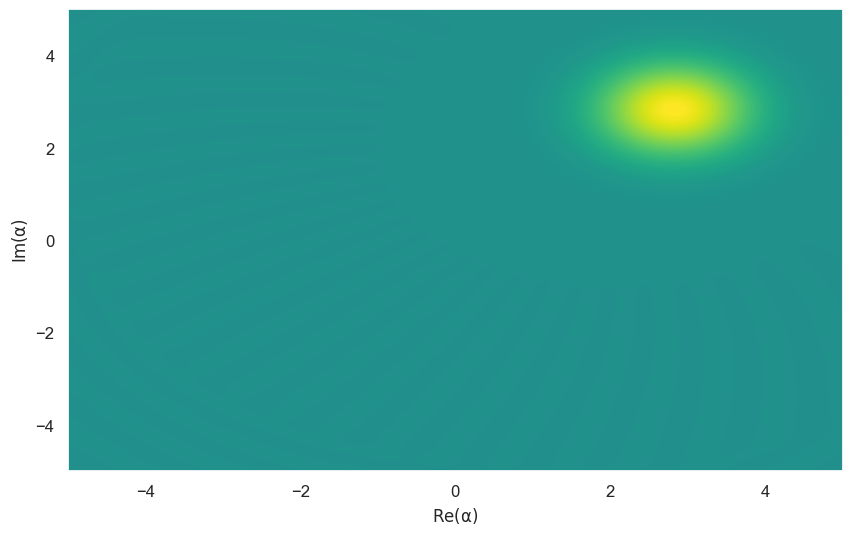

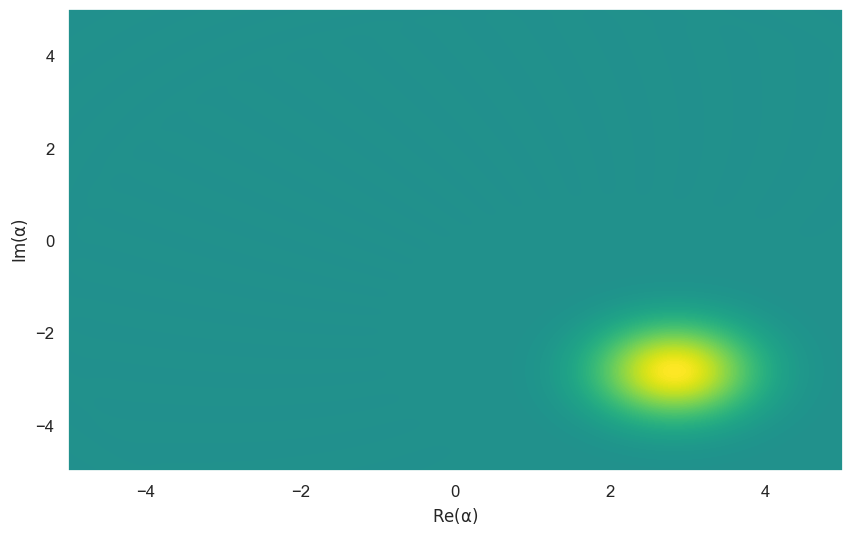

In [93]:
qt.plot_wigner(test, xvec=X, yvec=P, cmap="viridis", method="clenshaw")
qt.plot_wigner(rotate_state(test, np.pi/2), xvec=X, yvec=P, cmap="viridis", method="clenshaw")

## Computing marginal distributions


Compute marginals by rotating state and measure along $X$

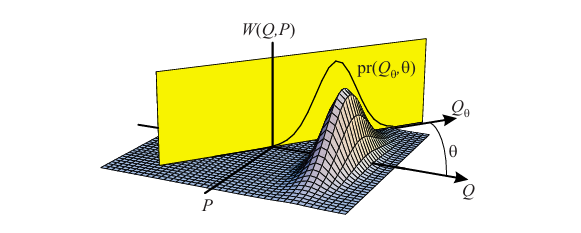

In [ ]:
def marginal_from_wigner(W, p, axis="x"):
    """
    Compute a marginal by integrating the Wigner function along one axis.  
    axis='p' gives ∫ W(x,p) dp -> P(x); axis='x' gives ∫ W(x,p) dx -> P(p).
    """
    if axis == "x":
        dx = p[1] - p[0]  # reuse grid spacing argument if needed
        P, dist = simpson(W, axis=1, dx=dx), dx  # integrate over x (position -- columns) return number of rows
    elif axis == "p":
        dp = p[1] - p[0]
        P, dist = simpson(W, axis=0, dx=dp), dp  # integrate over p (momentum -- rows) return number of columns
    else:
        raise ValueError("axis must be 'p' or 'x'")
    return P, dist


def marginal_angles(state, thetas, axis="p"):
    """
    Compute the marginal distributions for a range of rotation angles.
    """
    marginals = {}
    measurements = []
    thetalist = []
    for i in tqdm(range(len(thetas)), desc="Computing marginals"):
        rot = rotate_state(state, thetas[i])
        x, p, W = wigner_grid(rot, n=300, xmax=8, pmax=8)
        marginals[i], _ = marginal_from_wigner(W, p, axis=axis)
        thetalist.append([thetas[i]]*len(marginals[i]))
        measurements.append(marginals[i])
    
    if axis == "x": # variable of integration: p -- variable left in marginal: x
        marginals["P"] = p
    elif axis == "p": # variable of integration: x -- variable left in marginal: p
        marginals["X"] = x
    thetalist = np.array(thetalist)
    measurements = np.array(measurements)
    return marginals, np.array((thetalist.ravel(), measurements.ravel()))


# Create Data

In [52]:
state_type = "coherent"
alpha = 2.0 + 1j
parity = "even"
N_cutoff = 30  # dimension of the Hilbert space
state = generate_cv_state(state_type, N_cutoff, alpha=alpha, parity=parity)  # generate a state

n_theta = 12
thetas = [np.pi/n_theta * i for i in range(n_theta)]
marginals, measurements = marginal_angles(state, thetas, axis="p")

Computing marginals:   0%|          | 0/12 [00:00<?, ?it/s]

In [78]:
#check that the cumsum is 1
for i in range(len(thetas)):
    print(marginals[i].sum() * (marginals["X"][1] - marginals["X"][0]))

0.9999999999999041
0.9999999999984064
0.9999999999972541
0.9999999999993893
0.9999999999999906
0.9999999999999974
0.9999999999998712
0.9999999999978921
0.9999999999963716
0.9999999999991902
0.9999999999999866
0.9999999999999977


## Plot ground truth state

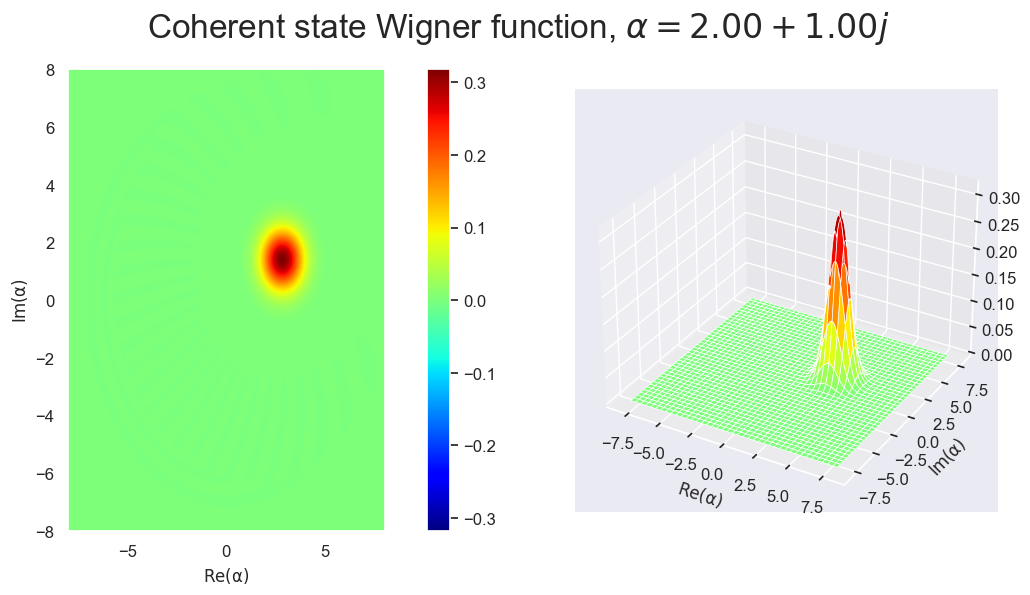

In [ ]:
fig = plt.figure(figsize=(12, 6)) # Initialize figure
cmap = "jet" # set colormap
ax1 = fig.add_subplot(1, 2, 1, aspect='auto') # add subplot for 2D Wigner function
ax2 = fig.add_subplot(1, 2, 2, projection="3d", aspect='auto') # add subplot for 3D Wigner function

# plot wigner function in 2D at axis 1
qt.plot_wigner(state, ax=ax1, cmap=cmap, xvec=np.linspace(-8, 8, 200), yvec=np.linspace(-8, 8, 200), projection="2d", method="laguerre", colorbar=True)

# plot wigner function in 3D at axis 2
qt.plot_wigner(state, ax=ax2, cmap=cmap, xvec=np.linspace(-8, 8, 200), yvec=np.linspace(-8, 8, 200), projection="3d", method="laguerre");

# set title
title = f"{state_type.capitalize()} state Wigner function, $\\alpha = {alpha:.2f}$"
if state_type == "cat":
    title += f",\nparity = {parity}"

fig.suptitle(title)
figname = f"plots/generated_{state_type}_state_WF"
if state_type in ["cat", "coherent"]:
    figname += f"_alpha_{alpha.real:.2f}_{alpha.imag:.2f}"
    if state_type == "cat":
        figname += f"_parity_{parity}"
figname += ".png"

# save figure
fig.savefig(figname)



## Save state

In [55]:
qt.fileio.qsave(state, filename="generated_state")
print("saved file to 'generated_state.qu'")

saved file to 'generated_state.qu'


## Plot marginals for all angles

Plotting marginals:   0%|          | 0/12 [00:00<?, ?it/s]

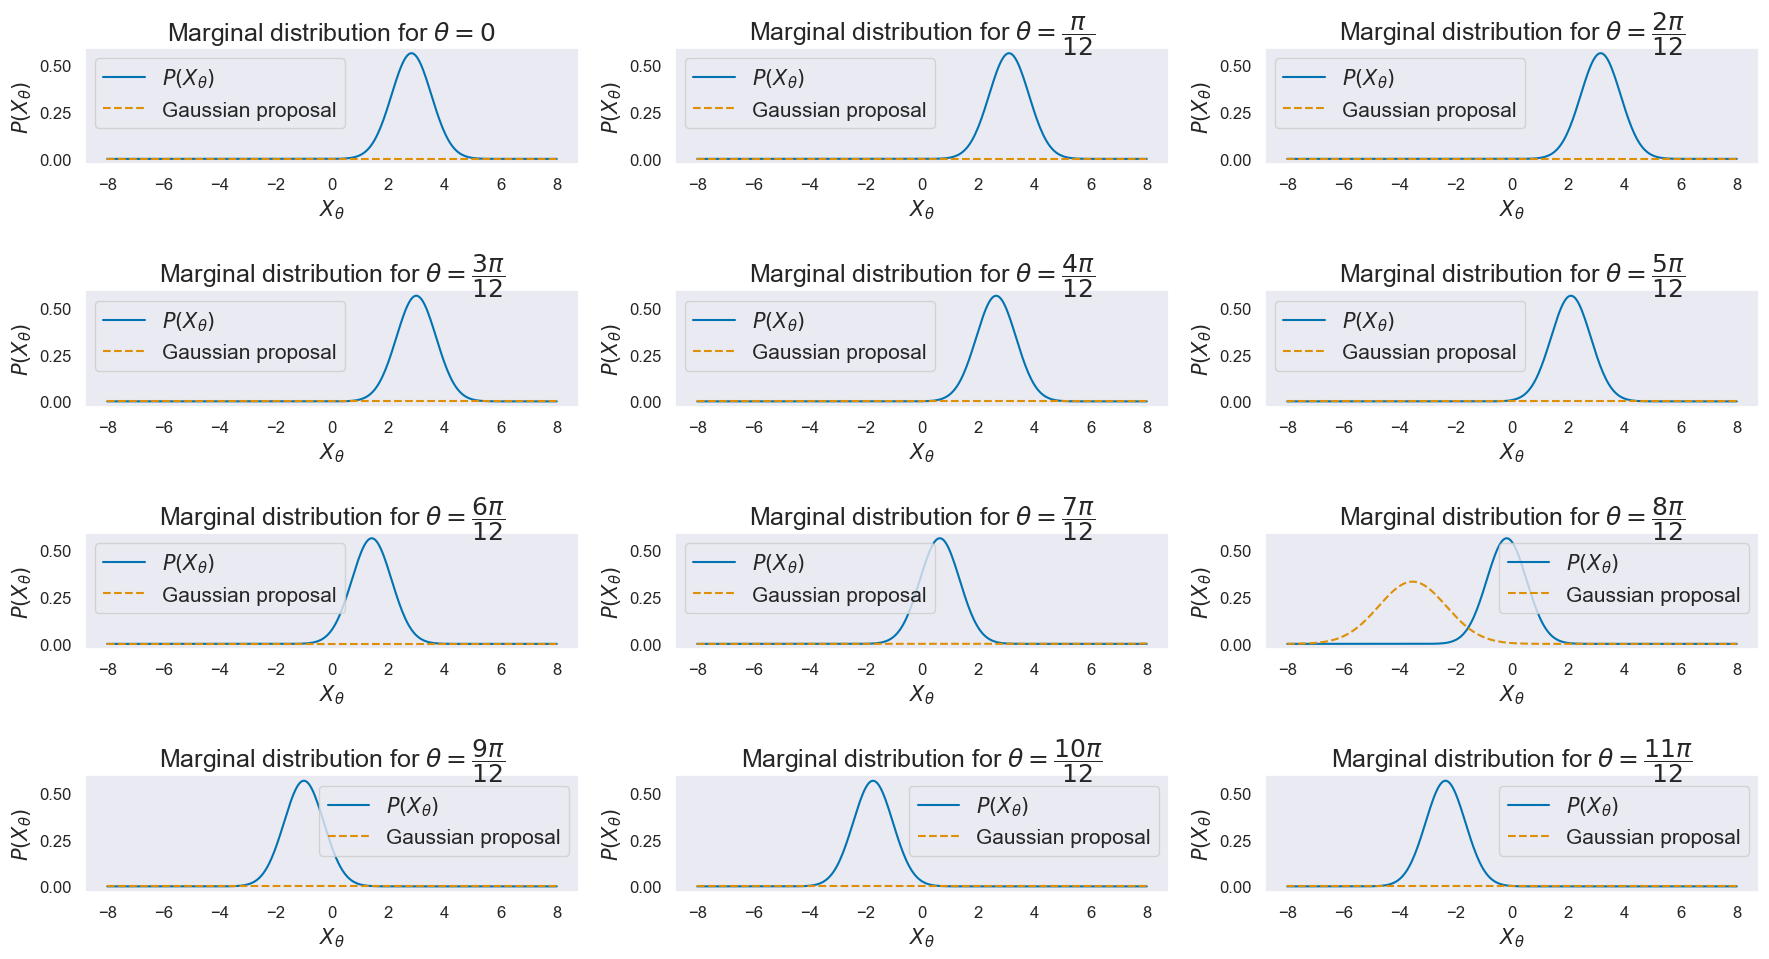

In [81]:
fig, axes = plt.subplots(n_theta // 3, 3, figsize=(18, 10))
labs = [r"$0$", rf"$\dfrac{{\pi}}{{{n_theta}}}$"] + [rf"$\dfrac{{{i}\pi}}{{{n_theta}}}$" for i in range(2, n_theta)]
axes = axes.flatten()
for i in tqdm(range(n_theta), desc="Plotting marginals"):
    ax = axes[i]
    ax.plot(marginals["X"], marginals[i], label=r"$P(X_{\theta})$")
    mu = marginals[i] @ marginals["X"] # <X> = sum_i p_i*x_i
    gaus = norm(loc=mu, scale=1.2).pdf(marginals["X"])
    ax.plot(marginals["X"], gaus, label="Gaussian proposal", linestyle="--")
    # ax.axvline(mu, color="k", linestyle="-", label="mean")
    ax.set_title(f"Marginal distribution for $\\theta=${labs[i]}")
    ax.set_xlabel(r"$X_{\theta}$")
    ax.set_ylabel(r"$P(X_{\theta})$")
    ax.legend()
    ax.grid()

fig.tight_layout()

## Sampling

### Rejection sampling
Not working -- yet

In [ ]:
def rejection_sampling(target_pdf, proposal_pdf, proposal_sampler, n_samples, i, marginals):
    
    samples = []
    with tqdm(total=n_samples, desc=f"Rejection sampling for theta={i/np.pi:.3f}pi") as pbar:
        while (len(samples) < n_samples): # condition
            xmin_index = np.argwhere(np.isclose(marginals[i], 0))[-1] # get the highest index for zero value
            xmax_index = np.argwhere(np.isclose(marginals[i], 0))[0] # get the lowest index for zero value
            x = proposal_sampler(xmin=marginals["X"][xmin_index], xmax=marginals["X"][xmax_index])  # Sample from proposal distribution
            if  marginals["X"].min() > x and x > marginals["X"].max():
                pbar.set_postfix({"rejected": x})
                pbar.update(0)
                continue  # Skip samples outside the range of marginals["X"]
            u = np.random.uniform(0, 1)
            
            q = proposal_pdf(x)
            
            p = target_pdf(x, i)
            if p is None:
                pbar.set_postfix({"rejected": x})
                pbar.update(0)
            elif u * q <= p:
                # print(f"appending {x:.3f}")
                samples.append(x)
                pbar.update(1)

    return samples

proposal_sampler = lambda: np.random.normal(loc=0, scale=1) # Example proposal sampler


### Sampling from the distribution

In [ ]:
def target_pdf(x, i=0):
    X = marginals["X"]
    index_mask = np.isclose(X, x, atol=5e-3)  # Adjusted tolerance
    index = np.argwhere(index_mask) # find index for bool

    assert len(index.shape) == 2, f"should always return a nested list"
    if index.shape[0] > 0:
        index = index[index.shape[0] // 2]
        return marginals[i][index]

    elif index.shape[0] == 0:
        return None


def get_samples(marginals, n_theta, n_samples=500, sampler="choice"):
    xs = {}  # initialize dictionary for samples
    for i in trange(n_theta, desc="Sampling"):
        target = lambda x, i=i: target_pdf(x, i)
        if sampler == "rejection":  # Rejection sampling --- not yet implemented
            # Proposal PDF
            proposal = norm(loc=marginals["X"] @ marginals[i], scale=1.2).pdf  
            raise NotImplementedError("Rejection sampling is not implemented yet.")
            xs[i] = rejection_sampling(target, proposal, proposal_sampler, n_samples=n_samples, i=i, marginals=marginals)
            
        # numpy choice sampling using marginals
        elif sampler == "choice":

            # find the step size. Raise error in neither "X" or "P" is in keys
            if "X" in marginals.keys():
                dx = marginals["X"][1] - marginals["X"][0]  # step size in integral
            elif "P" in marginals.keys():
                dx = marginals["P"][1] - marginals["P"][0]  # step size in integral
            else:
                raise ValueError("Marginals must contain 'X' or 'P' keys for sampling.")

            # compute the probability of each bin
            prob = marginals[i] * dx

            # find index for negative values
            index_negative = np.argwhere(prob < 0)

            # raise error if not all negative values close to zero
            if not (np.isclose(prob[index_negative], 0)).all():
                raise ValueError(f"prob negatives : {prob[index_negative].ravel()}")
            
            # set negative values to zero
            prob = np.where(prob < 0, 0, prob)

            # sample from the distribution
            xs[i] = np.random.choice(marginals["X"], p=prob, replace=True, size=n_samples)
        else: # unknown sampler
            raise ValueError(f"Unknown sampling type: {sampler}. Valid options are: ['choice', 'rejection'].")
    return xs

# Get samples from the marginals
samples = get_samples(marginals, n_theta=n_theta, n_samples=100_000, sampler="choice")

Sampling:   0%|          | 0/12 [00:00<?, ?it/s]

## Plot samples and marginals together

### Plots for all angles

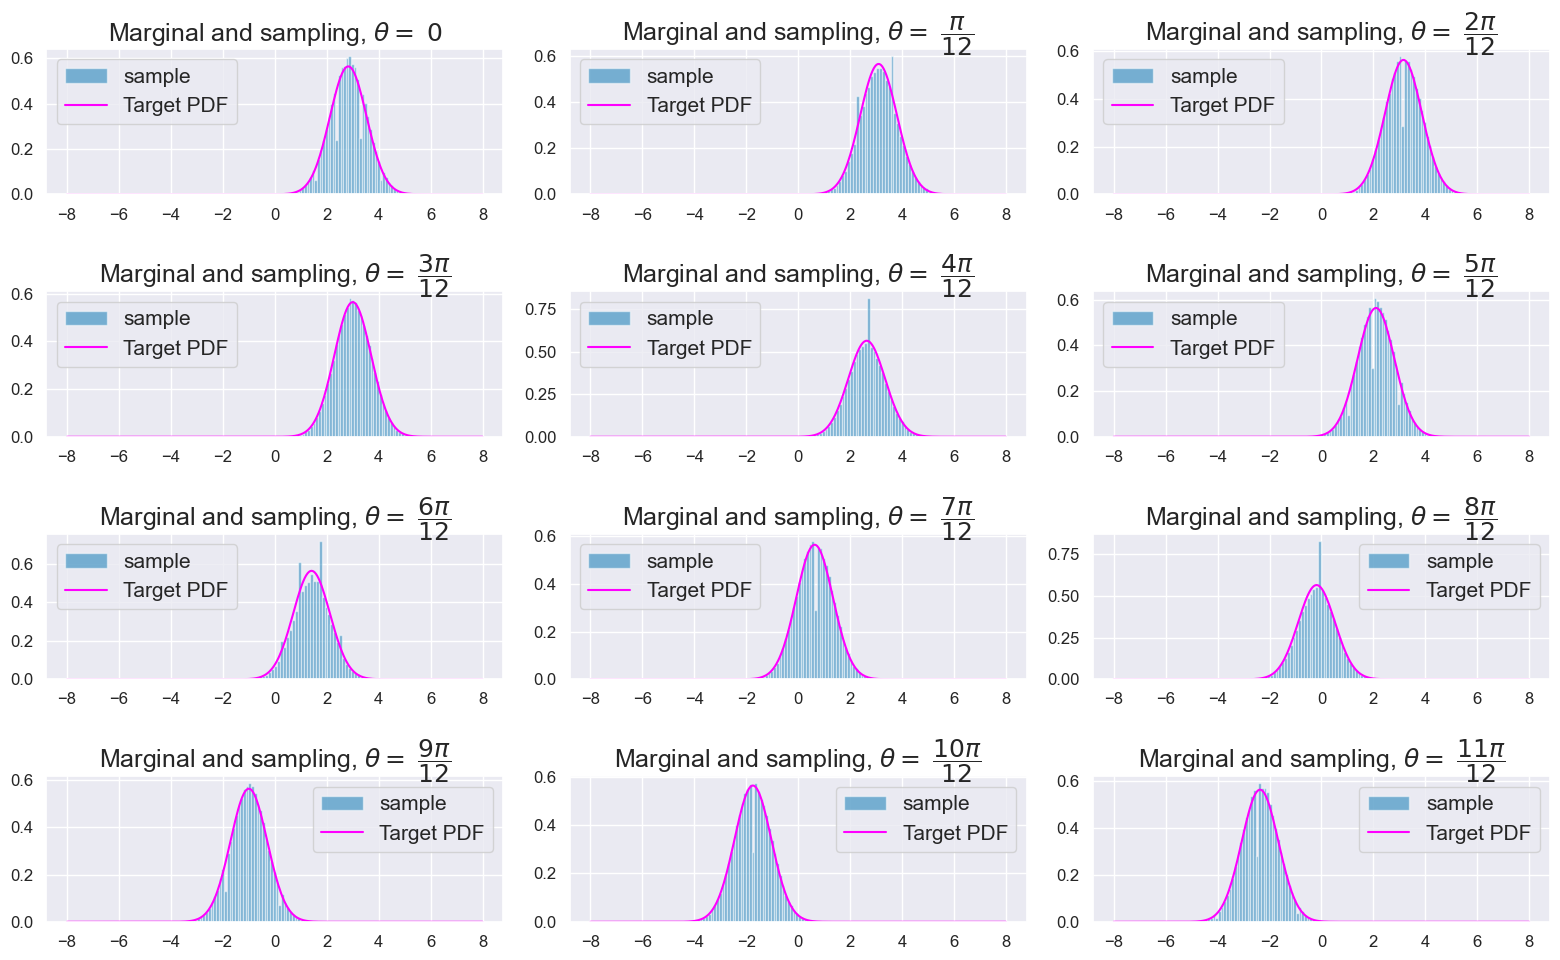

In [58]:
num_plots = n_theta // 3

fig, axes = plt.subplots(n_theta // 3, 3, figsize=(16, 10))
# axes = axes.flatten()
for i, ax in enumerate(axes.flatten()):
    ax.hist(samples[i], bins=60, density=True, label=f"sample", alpha=0.5)
    ax.plot(marginals["X"], marginals[i], label="Target PDF", color="magenta")
    # ax.plot(marginals["X"], norm.pdf(marginals["X"], loc=marginals["X"] @ marginals[i], scale=1.2), label="Proposal PDF", color="orange", linestyle="--")
    ax.set_title(f"Marginal and sampling, $\\theta =$ {labs[i]}")
    ax.legend()
    
fig.tight_layout()
    

### Plot only selected angles

Plotting angles: [  0.  75. 105. 135. 165.]


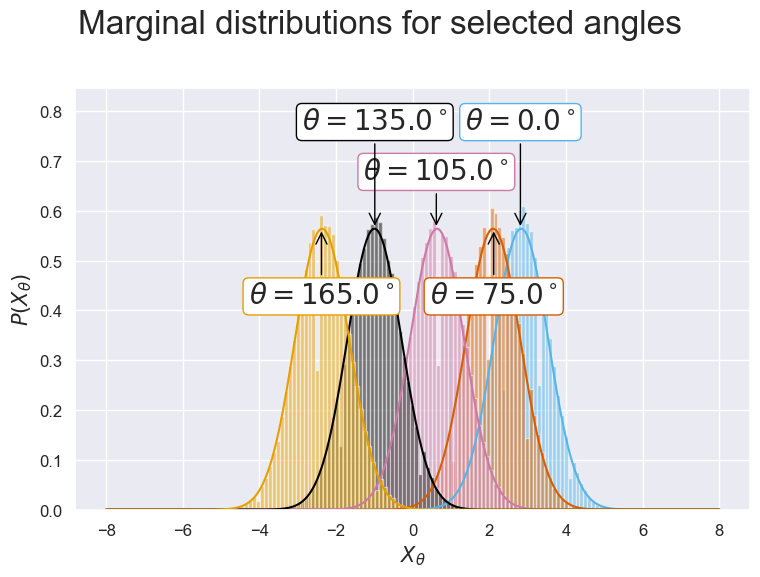

In [ ]:
def plot_selected_angles(data, samples, idxs, **kwargs):
    # list of angles in degrees
    angles = np.rad2deg([i*np.pi/len(samples) for i in idxs])
    print(f"Plotting angles: {angles}")
    
    
    default_colors = [
        "#56B4E9","#D55E00",
        "#CC79A7", "#000000", 
        "#E69F00","#009E73",
    ]


    # access args if provided otherwise use defaults
    colors = kwargs.get("colors", default_colors)
    bins = kwargs.get("bins", 60)
    density = kwargs.get("density", True)
    alpha = kwargs.get("alpha", 0.5)
    figsize = kwargs.get("figsize", (16, 10))


    # initialize figure
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    # access data 
    X = data["X"]
    
    # set labels and limits
    ax.set_xlabel(r"$X_{\theta}$")
    ax.set_ylabel(r"$P(X_{\theta})$")
    ax.set_ylim(bottom=0, top=1.5 * max(data[i].max() for i in idxs))


    # iterate over selected angles 
    for j, i in enumerate(idxs):

        # choose color code. Cycle through colors if exhausted
        col = colors[j % len(colors)]
        
        # plot histogram of samples and marginals
        ax.hist(samples[i], bins=bins, density=density, alpha=alpha, color=col)
        ax.plot(X, data[i], color=col)


        # annotate arrow placement
        xmax = X[np.argmax(data[i])]
        ymax = data[i].max()

        # compute shifts for annotation text
        xshift = 0
        yshift = 0.2 if j%3 == 0 else -0.15 if j%3 == 1 else 0.1 # will alternate height

        # set coordinates for arrow and text
        ann_arrow_point = (xmax, ymax)
        ann_text_place = (xmax + xshift, ymax + yshift)

        # annotate arrow placement
        ax.annotate(
            fr"$\theta = {angles[j]:.1f}^\circ$", # label
            xy=ann_arrow_point, # arrow point
            xytext=ann_text_place, # text position
            arrowprops=dict(arrowstyle="->", color="black"), # arrow properties
            ha="center", # horizontal alignment of text and arrow (otherwise slightly off)
            bbox=dict(boxstyle="round, pad=0.2", edgecolor=col, facecolor="white") # background box
        )

    # finalize -- title and layout
    fig.suptitle("Marginal distributions for selected angles")
    fig.tight_layout()
    return fig, ax

fig, ax = plot_selected_angles(marginals, samples, idxs=[0, 5, 7, 9, 11], figsize=(8,6)); 
fig.savefig("plots/marginal_distributions.png")


## Save measurement data

In [61]:
n_theta = len(samples)
T = np.array([np.pi/n_theta * i for i in range(n_theta)])
S = np.array([samples[i] for i in range(len(thetas))])
np.savez("measurements.npz", thetas=T, samples=S)
with open("measurements_metadata.txt", "w") as f:
    f.write(f"state_type,{state_type}\n")
    f.write(f"parity,{parity}\n")
    f.write(f"alpha,{alpha}\n")
    f.write(f"N_cutoff,{N_cutoff}\n")
    f.write(f"thetas [radians],{thetas}\n")


data = np.load("measurements.npz")
data["thetas"], data["samples"]


(array([0.        , 0.26179939, 0.52359878, 0.78539816, 1.04719755,
        1.30899694, 1.57079633, 1.83259571, 2.0943951 , 2.35619449,
        2.61799388, 2.87979327]),
 array([[ 3.23745819,  2.96989967,  4.36120401, ...,  2.75585284,
          3.34448161,  3.66555184],
        [ 3.82608696,  3.50501672,  4.09364548, ...,  2.64882943,
          3.71906355,  2.70234114],
        [ 2.16722408,  2.70234114,  3.50501672, ...,  3.61204013,
          3.13043478,  3.93311037],
        ...,
        [-0.4548495 , -0.02675585,  0.24080268, ..., -1.25752508,
          0.13377926, -1.63210702],
        [-2.80936455, -0.40133779, -1.63210702, ..., -2.3277592 ,
         -2.22073579, -1.04347826],
        [-2.48829431, -3.39799331, -1.52508361, ..., -3.50501672,
         -3.93311037, -2.27424749]], shape=(12, 100000)))